In [1]:
import numpy as np
import pandas as pd
import os
import itertools
from pandas.plotting import scatter_matrix
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from scipy import stats
import time
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (9,6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

In [2]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='green', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        
def RMSE_error(data,forecast):
    """
    This function gives the RMSE for the forecast
    """
    return np.sqrt((1/data.shape[0])*np.sum(np.square(data-forecast)))

In [3]:
xlsx = pd.ExcelFile('KOSPI.xlsx')
df = pd.read_excel(xlsx, 'Sheet1')
df.head()
df_noindex = df.copy()
df.head()

,Date,KOSPI,XPI,EIEI,Chi_PMI,Phil_FMI,K_CLI,K_CCI,K_CCI12,K_Cconf,...,Brent,C_MPI,C_RSG,JPY_USD,EUR_USD,CNY_USD,KRW_USD,U_Cconf,10_3_TCM,CGIPI
0,2010/01,1602.43,117.23,73.7,59,12.9,84.3,82.6,0.097656,116.2,...,76.17,60.5,0.140,91.25,0.699692,6.8276,1138.82,55.9,1.06,108.60
1,2010/02,1594.58,118.67,77.1,57.3,13.9,84.4,83.3,0.090439,113.7,...,73.75,54.3,0.221,90.29,0.730247,6.8293,1157.08,46.0,1.11,110.02
2,2010/03,1692.85,118.16,95.8,59.1,14.2,84.4,84.0,0.082051,113.6,...,78.83,58.4,0.180,90.61,0.736377,6.8268,1137.64,52.5,0.98,107.96
3,2010/04,1741.56,118.47,89.8,60.9,16.0,84.5,84.5,0.066919,113.3,...,84.82,59.1,0.185,93.46,0.743937,6.8259,1117.11,57.9,1.14,105.16
4,2010/05,1641.25,121.41,85.9,63.8,22.2,84.7,85.2,0.060075,113.4,...,75.95,58.2,0.187,91.99,0.795798,6.8276,1163.11,63.3,1.25,109.08


In [4]:
corr = df.corr()
corrlist = corr['KOSPI'].values
p = []
for i in range(len(corrlist)):
    if corrlist[i] < 0.5:
        p.append(corr['KOSPI'].index[i])
    else:
        pass
#print(p)
DF = df.drop(columns=p)
DF['Date'] = pd.to_datetime(DF['Date'])
DF = DF.set_index('Date')
#DF.head()

[0.6951316634769293, 0.08724373594703136, 0.07109566390165245, 0.050041729434339356, 0.03619281311995519, 0.018970194562615453, 0.012988890065108066, 0.008791024562429004, 0.005672139587964506, 0.004462392455240017, 0.0035531696095250464, 0.0024510533198250748, 0.0015788499005458087, 0.0010084968207903432, 0.0005297837893127939, 2.2647339597779705e-05, 7.604656899110869e-05, 0.00018970553814740763]
[0.69513166 0.7823754  0.85347106 0.90351279 0.93970561 0.9586758
 0.97166469 0.98045572 0.98612785 0.99059025 0.99414342 0.99659447
 0.99817332 0.99918182 0.9997116  0.99973425 0.99981029 1.        ]


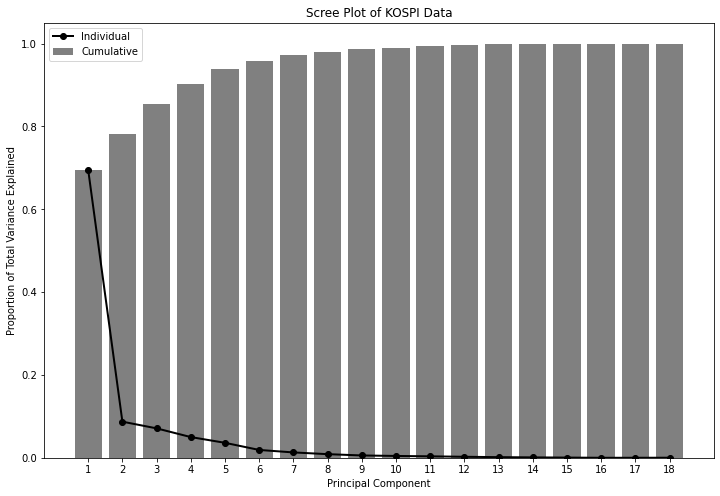

In [78]:
#PCA
DF_PCA = DF.drop(columns='KOSPI')
DF_scaled = StandardScaler().fit_transform(DF_PCA)
features = DF_scaled.T
cov_matrix = np.cov(features)
values, vectors = np.linalg.eig(cov_matrix)
explained_variances = []
PCn = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
    PCn.append(i+1)
plt.figure(figsize = (12,8))
plt.plot(PCn, explained_variances, 'o-', linewidth=2, color='black', label = 'Individual')
plt.title('Scree Plot of KOSPI Data')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Total Variance Explained')
plt.bar(PCn, np.cumsum(explained_variances), color='grey', label = 'Cumulative', tick_label = np.arange(1,19))
plt.legend(loc='best')
print(explained_variances)
print(np.cumsum(explained_variances))
plt.show()

,KOSPI,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Date,,,,,,,,
2010-01-01,1602.43,-5.916924,-1.003081,-0.992712,-0.399996,1.100517,0.145524,0.951043
2010-02-01,1594.58,-5.955874,-0.932622,-1.003503,-0.155117,1.360442,0.192021,0.471728
2010-03-01,1692.85,-5.052478,-1.166979,-0.936958,-1.145191,0.894280,0.055430,-0.277152
2010-04-01,1741.56,-5.102206,-1.315718,-0.650060,-0.690265,0.571890,0.078707,0.059481
2010-05-01,1641.25,-4.934691,-1.687144,-0.216835,-0.664237,-0.049710,0.350314,0.511166
...,...,...,...,...,...,...,...,...
2022-01-01,2663.34,6.287056,-0.443820,1.641003,0.852056,0.459548,-0.521875,0.241780
2022-02-01,2699.18,5.651933,0.760010,1.357241,1.779484,1.184782,-0.226158,0.090864
2022-03-01,2757.65,5.891340,0.044120,2.608946,-0.642513,-0.118102,0.220185,-0.511722


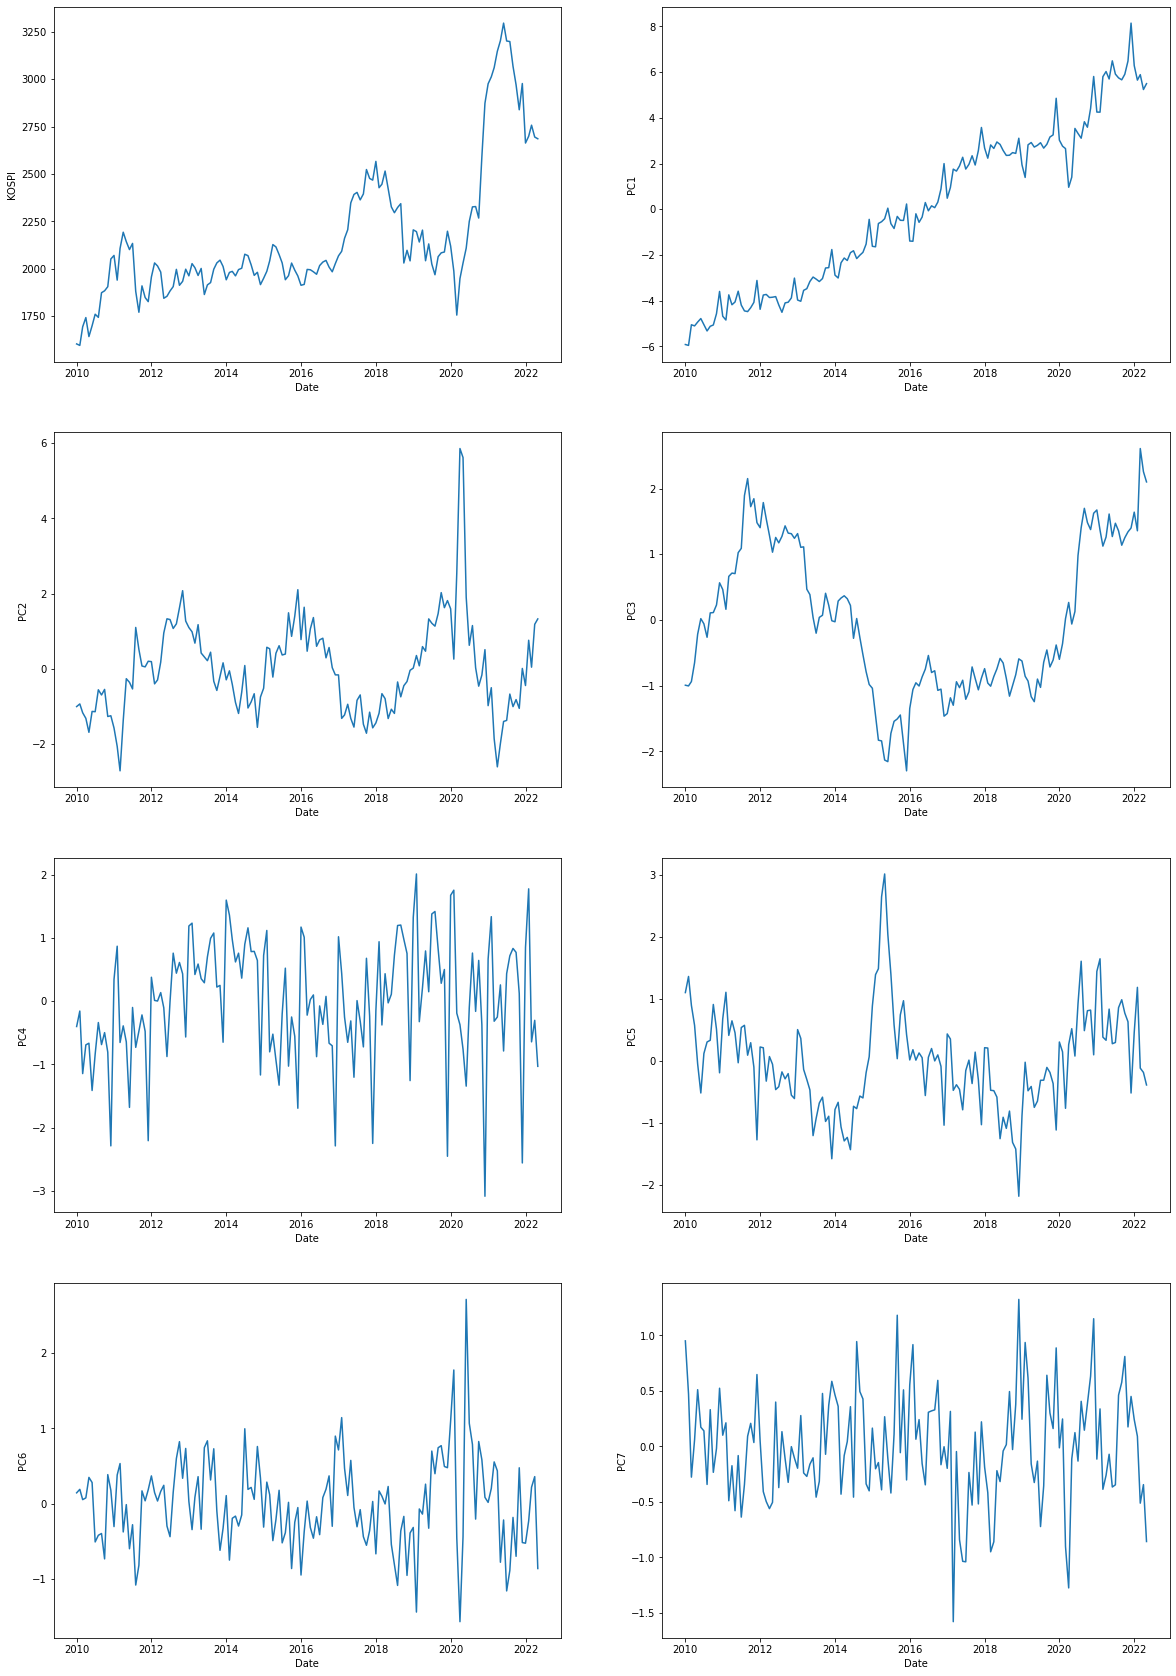

In [95]:
KOSPI_list = DF['KOSPI'].to_list()
PC1_df = pd.DataFrame(DF_scaled.dot(vectors.T[0]), columns = ['PC1'])
PC2_df = pd.DataFrame(DF_scaled.dot(vectors.T[1]), columns = ['PC2'])
PC3_df = pd.DataFrame(DF_scaled.dot(vectors.T[2]), columns = ['PC3'])
PC4_df = pd.DataFrame(DF_scaled.dot(vectors.T[3]), columns = ['PC4'])
PC5_df = pd.DataFrame(DF_scaled.dot(vectors.T[4]), columns = ['PC5'])
PC6_df = pd.DataFrame(DF_scaled.dot(vectors.T[5]), columns = ['PC6'])
PC7_df = pd.DataFrame(DF_scaled.dot(vectors.T[6]), columns = ['PC7'])
PCAd = {'KOSPI': KOSPI_list, 'PC1' : DF_scaled.dot(vectors.T[0]), 'PC2' : DF_scaled.dot(vectors.T[1])
        , 'PC3' : DF_scaled.dot(vectors.T[2]), 'PC4' : DF_scaled.dot(vectors.T[3]), 
        'PC5' : DF_scaled.dot(vectors.T[4]), 'PC6' : DF_scaled.dot(vectors.T[5]), 
        'PC7' : DF_scaled.dot(vectors.T[6])}
PCA_df = pd.DataFrame(data = PCAd) #All merged together
PCA_df.index = DF.index
#sns.lineplot(x = PCA_df.index, y = PCA_df['KOSPI'])
fig, axs = plt.subplots(4, 2)
mpl.rcParams['figure.figsize'] = (30,20)
sns.lineplot(ax = axs[0, 0], x = PCA_df.index, y = PCA_df['KOSPI'])
sns.lineplot(ax = axs[0, 1], x = PCA_df.index, y = PCA_df['PC1'])
sns.lineplot(ax = axs[1, 0], x = PCA_df.index, y = PCA_df['PC2'])
sns.lineplot(ax = axs[1, 1], x = PCA_df.index, y = PCA_df['PC3'])
sns.lineplot(ax = axs[2, 0], x = PCA_df.index, y = PCA_df['PC4'])
sns.lineplot(ax = axs[2, 1], x = PCA_df.index, y = PCA_df['PC5'])
sns.lineplot(ax = axs[3, 0], x = PCA_df.index, y = PCA_df['PC6'])
sns.lineplot(ax = axs[3, 1], x = PCA_df.index, y = PCA_df['PC7'])
display(PCA_df)

In [45]:
maxlag=12
Grangerdf = PCA_df.set_index(np.arange(len(PCA_df.index)))
#display(Grangerdf)
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    Grangerdf = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in Grangerdf.columns:
        for r in Grangerdf.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            Grangerdf.loc[r, c] = min_p_value
    Grangerdf.columns = [var + '_x' for var in variables]
    Grangerdf.index = [var + '_y' for var in variables]
    return Grangerdf
#grangers_causation_matrix(Grangerdf, variables = Grangerdf.columns)   

In [9]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

#cointegration_test(Grangerdf)

In [98]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [57]:
PCA_new = PCA_df
PCA_new6 = PCA_df.drop('PC7', axis = 1)
PCA_new5 = PCA_df.drop(['PC6', 'PC7'], axis = 1)
PCA_new4 = PCA_df.drop(['PC5', 'PC6', 'PC7'], axis = 1)
PCA_new3 = PCA_df.drop(['PC4', 'PC5', 'PC6', 'PC7'], axis = 1)
PCA_new2 = PCA_df.drop(['PC3', 'PC4', 'PC5', 'PC6', 'PC7'], axis = 1)
PCA_new1 = PCA_df.drop(['PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7'], axis = 1)
df_differenced = PCA_new.diff().dropna()
df_differenced1 = PCA_new1.diff().dropna()
df_differenced2 = PCA_new2.diff().dropna()
df_differenced3 = PCA_new3.diff().dropna()
df_differenced4 = PCA_new4.diff().dropna()
df_differenced5 = PCA_new5.diff().dropna()
df_differenced6 = PCA_new6.diff().dropna()

In [58]:
nobs = 12
df_train, df_test = PCA_new[0:-nobs], PCA_new[-nobs:]
df_train1, df_test1 = PCA_new1[0:-nobs], PCA_new1[-nobs:]
df_train2, df_test2 = PCA_new2[0:-nobs], PCA_new2[-nobs:]
df_train3, df_test3 = PCA_new3[0:-nobs], PCA_new3[-nobs:]
df_train4, df_test4 = PCA_new4[0:-nobs], PCA_new4[-nobs:]
df_train5, df_test5 = PCA_new5[0:-nobs], PCA_new5[-nobs:]
df_train6, df_test6 = PCA_new6[0:-nobs], PCA_new6[-nobs:]
df_d_train, df_d_test = df_differenced[0:-nobs], df_differenced[-nobs:]
df_d_train1, df_d_test1 = df_differenced1[0:-nobs], df_differenced1[-nobs:]
df_d_train2, df_d_test2 = df_differenced2[0:-nobs], df_differenced2[-nobs:]
df_d_train3, df_d_test3 = df_differenced3[0:-nobs], df_differenced3[-nobs:]
df_d_train4, df_d_test4 = df_differenced4[0:-nobs], df_differenced4[-nobs:]
df_d_train5, df_d_test5 = df_differenced5[0:-nobs], df_differenced5[-nobs:]
df_d_train6, df_d_test6 = df_differenced6[0:-nobs], df_differenced6[-nobs:]

In [156]:
def AIC(data):
    modelcheck = VAR(data)
    aic = []
    for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
        result = modelcheck.fit(i)
        aic.append(result.aic)
    return aic
aic1 = AIC(df_d_train1)
aic2 = AIC(df_d_train2)
aic3 = AIC(df_d_train3)
aic4 = AIC(df_d_train4)
aic5 = AIC(df_d_train5)
aic6 = AIC(df_d_train6)
aic7 = AIC(df_d_train)
aic_dict = {'Lags': np.arange(1,13), 'PC1':aic1, 'PC2':aic2, 'PC3':aic3, 'PC4':aic4, 'PC5':aic5, 'PC6':aic6, 'PC7':aic7}
aic_DF = pd.DataFrame(data = aic_dict)
aic_DF = aic_DF.set_index('Lags')
aic_DF

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: Valu

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Lags,,,,,,,
1,8.076446,7.456975,4.807337,2.714631,0.613878,-0.987412,-2.522153
2,7.816378,7.063047,4.508865,2.417719,0.410929,-1.223318,-2.828749
3,7.860817,7.173968,4.690491,2.574508,0.557816,-1.042166,-2.583293
4,7.778511,7.103583,4.626323,2.603390,0.626341,-0.923301,-2.357697
5,7.772889,7.057401,4.618093,2.473919,0.442866,-1.193383,-2.676751
6,7.803063,7.091964,4.710317,2.688162,0.717448,-0.854567,-2.302775
7,7.835511,7.171899,4.804872,2.840339,0.760385,-0.694218,-2.187413
8,7.857592,7.146656,4.849723,2.979484,0.975341,-0.553831,-2.189113
9,7.911398,7.169680,4.990500,3.013181,0.851219,-0.635080,-2.838590


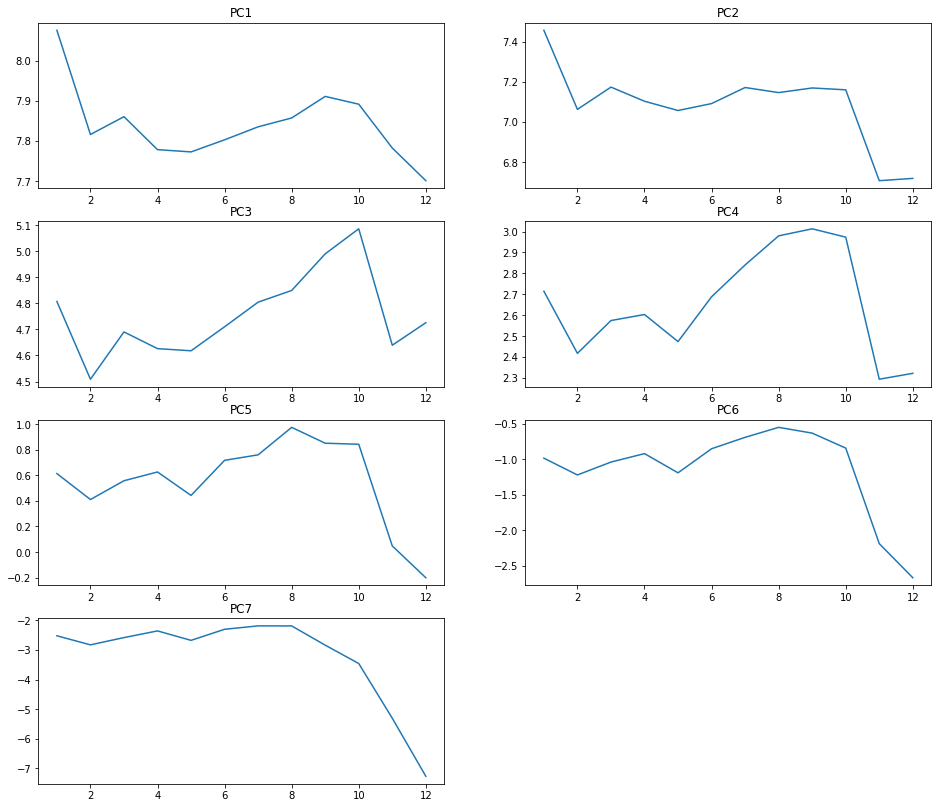

In [159]:
mpl.rcParams['figure.figsize'] = (16,14)
for i in np.arange(0,7):
    plt.subplot(4,2,i+1)
    plt.title('PC{}'.format(i+1))
    plt.plot(pd.DataFrame(aic_DF['PC{}'.format(i+1)], index = aic_DF.index))

In [22]:
def opt_VARMAX(test, train, p, q):
    model = VARMAX(train, order=(p,q), trend = 'ct')
    model_fit = model.fit()
    eq = model_fit.summary()
    pred = model_fit.forecast(nobs)
    pred_val = model_fit.get_forecast(steps = nobs)
    return RMSE_error(test['KOSPI'],pred['KOSPI']), pred_val.summary_frame(), eq
def RMSE_VARMAX_df(test, train, plist, qlist):
    RMSE_i = []
    RMSE = []
    summarylist = []
    for p, q in itertools.product(plist, qlist):
        error, summary, eq = opt_VARMAX(test, train, int(p), int(q))
        RMSE.append(error)
        RMSE_i.append((p, q))
        summarylist.append(summary)
    return RMSE, RMSE_i, summarylist, eq
def plot_VARMAX(original, train, p, q):
    error, predsumm, eq = opt_VARMAX(original[-nobs:], train, p, q)
    pred = predsumm['mean']
    conf_int_l = predsumm['mean_ci_lower']
    conf_int_u = predsumm['mean_ci_upper']
    plt.figure(figsize = (7,5))
    plt.plot(original['KOSPI'][-nobs:], label = 'Original')
    plt.plot(pred, label = 'Forecast')
    plt.fill_between(predsumm.index, conf_int_l, conf_int_u, alpha = 0.2, label = 'Confidence Interval')
    plt.figure(figsize = (7,5))
    plt.plot(original['KOSPI'], label = 'Original')
    plt.plot(pred, label = 'Forecast')
    plt.fill_between(predsumm.index, conf_int_l, conf_int_u, alpha = 0.2, label = 'Confidence Interval')
    plt.legend()
    print('Root mean squared error: {}'.format(error))
    return predsumm, eq

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of

Root mean squared error: 111.65852941219718


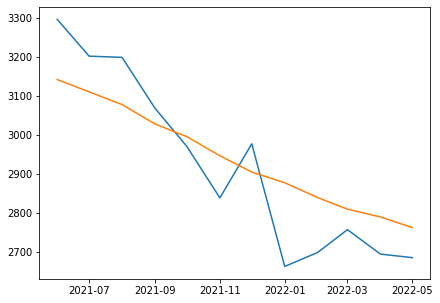

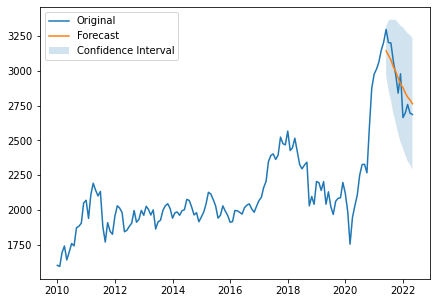

In [31]:
predsumm1, eq1 = plot_VARMAX(PCA_new1, df_train1, 5,5)

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of

Root mean squared error: 121.34136242466501


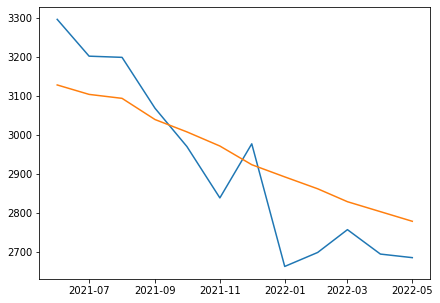

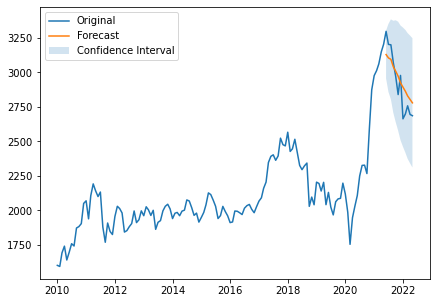

In [32]:
predsumm2, eq2 = plot_VARMAX(PCA_new2, df_train2, 5,4)

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of

Root mean squared error: 337.2459849374364


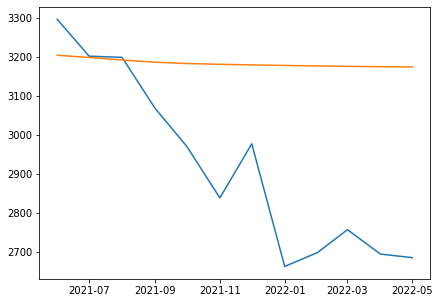

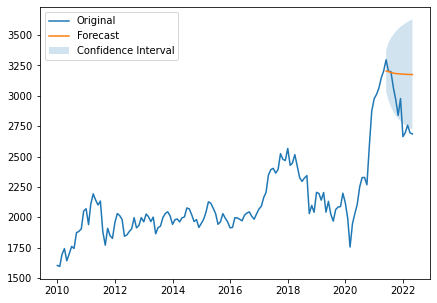

In [33]:
predsumm3, eq3 = plot_VARMAX(PCA_new3, df_train3, 2,1)

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of

Root mean squared error: 146.79455835425296


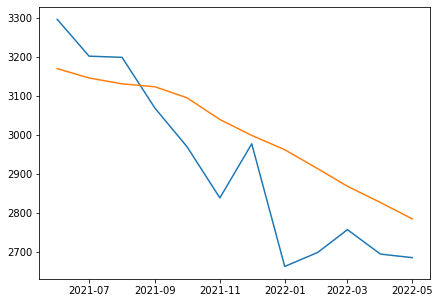

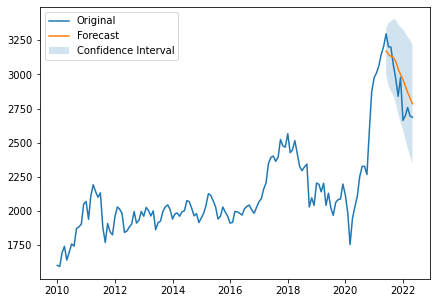

In [34]:
predsumm4, eq4 = plot_VARMAX(PCA_new4, df_train4, 5,3)

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of

Root mean squared error: 143.861511145343


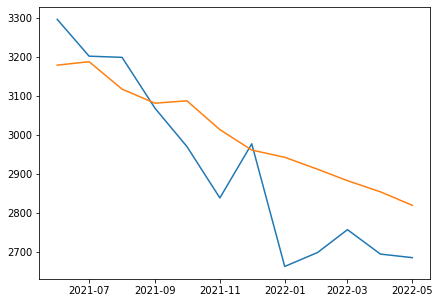

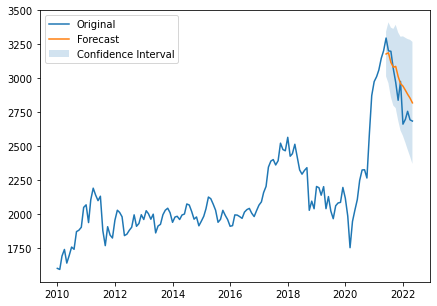

In [35]:
predsumm5, eq5 = plot_VARMAX(PCA_new5, df_train5, 5,6)

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of

Root mean squared error: 91.6655269113457


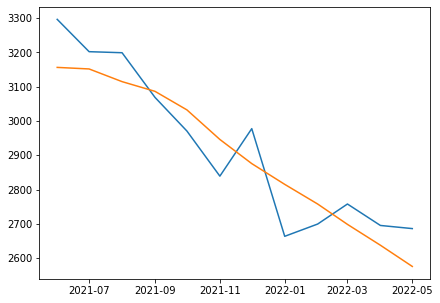

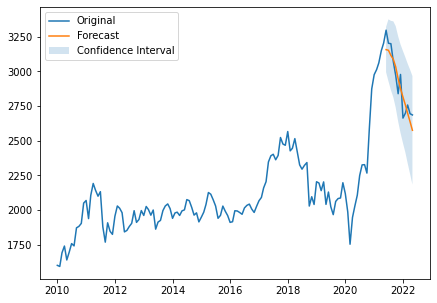

In [36]:
predsumm6, eq6 = plot_VARMAX(PCA_new6, df_train6, 5,5)

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

Root mean squared error: 96.17632311047149


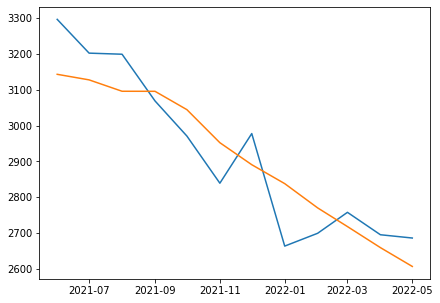

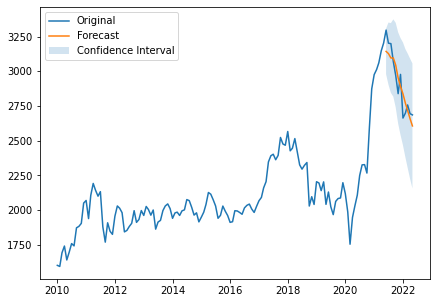

In [39]:
predsumm7, eq7 = plot_VARMAX(PCA_new, df_train, 5,12)

In [168]:
print(predsumm1)
print(eq1)

KOSPI              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  3142.342060   88.787722    2968.321323    3316.362796
2021-07-01  3110.885564  126.288578    2863.364499    3358.406628
2021-08-01  3078.223282  148.279105    2787.601576    3368.844987
2021-09-01  3028.534155  171.593585    2692.216908    3364.851402
2021-10-01  2995.882227  188.839379    2625.763845    3366.000609
2021-11-01  2947.062311  202.491154    2550.186942    3343.937680
2021-12-01  2905.250113  213.189551    2487.406270    3323.093955
2022-01-01  2877.936261  221.944138    2442.933744    3312.938778
2022-02-01  2839.855360  228.743887    2391.525581    3288.185140
2022-03-01  2810.191251  233.895195    2351.765092    3268.617409
2022-04-01  2790.177082  237.983939    2323.737132    3256.617032
2022-05-01  2763.054121  241.100012    2290.506780    3235.601461
                           Statespace Model Results                           
Dep. Variable:       ['KOSPI', 'PC1']   No. Observations:      

In [169]:
print(predsumm2)
print(eq2)

KOSPI              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  3128.537838   88.550825    2954.981410    3302.094265
2021-07-01  3104.344971  125.732984    2857.912852    3350.777091
2021-08-01  3094.202562  147.637007    2804.839345    3383.565779
2021-09-01  3039.874916  170.193830    2706.301139    3373.448692
2021-10-01  3008.237152  188.155952    2639.458263    3377.016041
2021-11-01  2971.997085  201.362072    2577.334676    3366.659495
2021-12-01  2924.128824  211.788569    2509.030856    3339.226792
2022-01-01  2892.904628  220.048902    2461.616705    3324.192552
2022-02-01  2862.392780  226.789030    2417.894449    3306.891110
2022-03-01  2829.273845  232.086517    2374.392630    3284.155060
2022-04-01  2803.767530  235.961273    2341.291934    3266.243126
2022-05-01  2779.111641  238.839436    2310.994949    3247.228334
                              Statespace Model Results                             
Dep. Variable:     ['KOSPI', 'PC1', 'PC2']   No. Observati

In [170]:
print(predsumm3)
print(eq3)

KOSPI              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  3204.591558   85.685895    3036.650289    3372.532826
2021-07-01  3199.051269  121.160160    2961.581719    3436.520820
2021-08-01  3192.453793  144.290638    2909.649340    3475.258247
2021-09-01  3186.831610  162.030481    2869.257702    3504.405517
2021-10-01  3183.476206  176.358505    2837.819888    3529.132524
2021-11-01  3181.472416  188.216647    2812.574567    3550.370264
2021-12-01  3179.913058  198.214187    2791.420389    3568.405726
2022-01-01  3178.525075  206.787936    2773.228167    3583.821983
2022-02-01  3177.299626  214.257675    2757.362299    3597.236954
2022-03-01  3176.250952  220.858474    2743.376297    3609.125607
2022-04-01  3175.381923  226.764877    2730.930931    3619.832914
2022-05-01  3174.695927  232.107964    2719.772676    3629.619178
                                 Statespace Model Results                                 
Dep. Variable:     ['KOSPI', 'PC1', 'PC2', 'PC3']  

In [171]:
print(predsumm4)
print(eq4)

KOSPI              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  3170.392531   85.498060    3002.819412    3337.965650
2021-07-01  3146.423776  116.173475    2918.727950    3374.119603
2021-08-01  3131.415953  130.454188    2875.730444    3387.101463
2021-09-01  3123.871624  142.150940    2845.260902    3402.482346
2021-10-01  3095.794074  155.157448    2791.691065    3399.897084
2021-11-01  3039.982603  166.958830    2712.749310    3367.215896
2021-12-01  2999.190031  177.089314    2652.101353    3346.278709
2022-01-01  2962.584400  187.876092    2594.354027    3330.814773
2022-02-01  2913.928465  197.894629    2526.062120    3301.794811
2022-03-01  2868.831035  207.170844    2462.783643    3274.878427
2022-04-01  2827.288308  215.939844    2404.053992    3250.522625
2022-05-01  2785.178114  223.455987    2347.212428    3223.143800
                                     Statespace Model Results                                    
Dep. Variable:     ['KOSPI', 'PC1', 'PC2', '

In [172]:
print(predsumm5)
print(eq5)

KOSPI              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  3179.270443   84.215531    3014.211035    3344.329850
2021-07-01  3188.148313  114.237667    2964.246600    3412.050026
2021-08-01  3117.802725  130.374627    2862.273151    3373.332300
2021-09-01  3081.827984  143.998385    2799.596335    3364.059632
2021-10-01  3087.913332  156.201446    2781.764124    3394.062540
2021-11-01  3013.984441  165.134152    2690.327449    3337.641432
2021-12-01  2961.683963  175.882657    2616.960290    3306.407635
2022-01-01  2943.101151  186.813015    2576.954369    3309.247934
2022-02-01  2912.412477  196.965273    2526.367635    3298.457319
2022-03-01  2883.208039  207.256232    2476.993288    3289.422790
2022-04-01  2854.638831  218.768228    2425.860984    3283.416679
2022-05-01  2819.986601  228.991462    2371.171582    3268.801620
                                        Statespace Model Results                                        
Dep. Variable:     ['KOSPI', 'PC1', '

In [173]:
print(predsumm6)
print(eq6)

KOSPI              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  3156.448385   83.204103    2993.371339    3319.525430
2021-07-01  3151.894305  113.650984    2929.142469    3374.646141
2021-08-01  3114.888839  127.143036    2865.693067    3364.084610
2021-09-01  3086.530395  139.656902    2812.807898    3360.252892
2021-10-01  3032.434021  149.645424    2739.134380    3325.733661
2021-11-01  2946.084606  156.431258    2639.484975    3252.684237
2021-12-01  2875.607141  162.601833    2556.913405    3194.300877
2022-01-01  2815.031941  169.155781    2483.492702    3146.571179
2022-02-01  2757.600561  175.002365    2414.602227    3100.598894
2022-03-01  2698.235778  182.730425    2340.090726    3056.380830
2022-04-01  2637.319154  191.445339    2262.093185    3012.545122
2022-05-01  2575.393221  199.700278    2183.987869    2966.798574
                                            Statespace Model Results                                           
Dep. Variable:     ['KOSPI', '

In [174]:
print(predsumm7)
print(eq7)

KOSPI              mean     mean_se  mean_ci_lower  mean_ci_upper
2021-06-01  3143.188105   83.686783    2979.165025    3307.211185
2021-07-01  3127.631983  114.043001    2904.111808    3351.152157
2021-08-01  3095.839769  128.300473    2844.375462    3347.304075
2021-09-01  3095.693518  142.047940    2817.284671    3374.102366
2021-10-01  3044.442752  155.525267    2739.618830    3349.266674
2021-11-01  2952.151241  167.625067    2623.612147    3280.690335
2021-12-01  2890.695426  177.903762    2542.010460    3239.380391
2022-01-01  2837.826341  188.833618    2467.719252    3207.933431
2022-02-01  2770.001559  198.836611    2380.288963    3159.714155
2022-03-01  2717.895510  209.822821    2306.650338    3129.140682
2022-04-01  2659.100488  220.724506    2226.488407    3091.712569
2022-05-01  2606.504688  229.580875    2156.534441    3056.474935
                                               Statespace Model Results                                               
Dep. Variable:     ['KO

In [40]:
PCA_new1246 = PCA_df.drop(['PC3', 'PC5', 'PC7'], axis = 1)
df_differenced1246 = PCA_new.diff().dropna()
df_train1246, df_test1246 = PCA_new1246[0:-nobs], PCA_new1246[-nobs:]
df_d_train1246, df_d_test1246 = df_differenced1246[0:-nobs], df_differenced1246[-nobs:]

C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\leegj\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of

Root mean squared error: 100.79423624444182


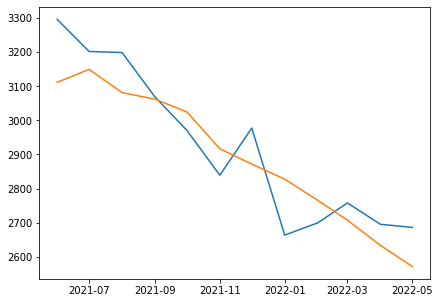

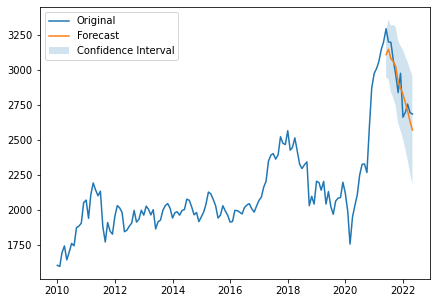

In [41]:
predsumm1246, eq1246 = plot_VARMAX(PCA_new1246, df_train1246, 5,9)